--- Project: Advanced House Price Prediction ---
Setup complete. Using LightGBM model.

Dataset loaded successfully.

Performing Exploratory Data Analysis (EDA)...


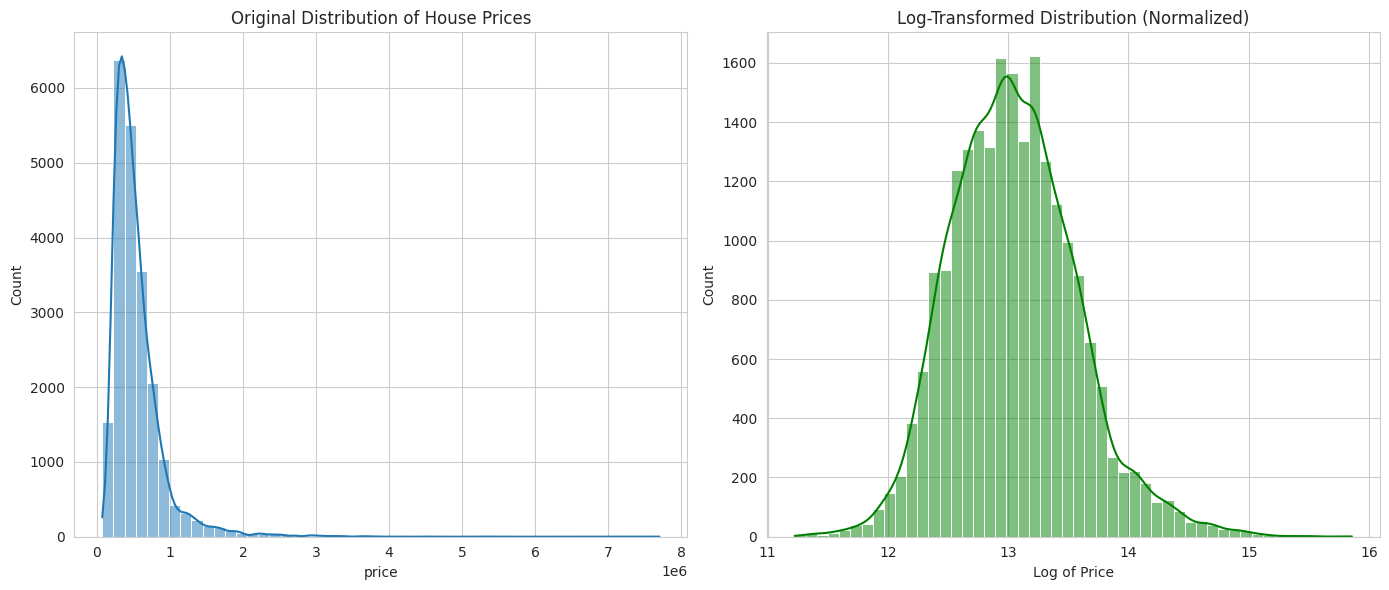

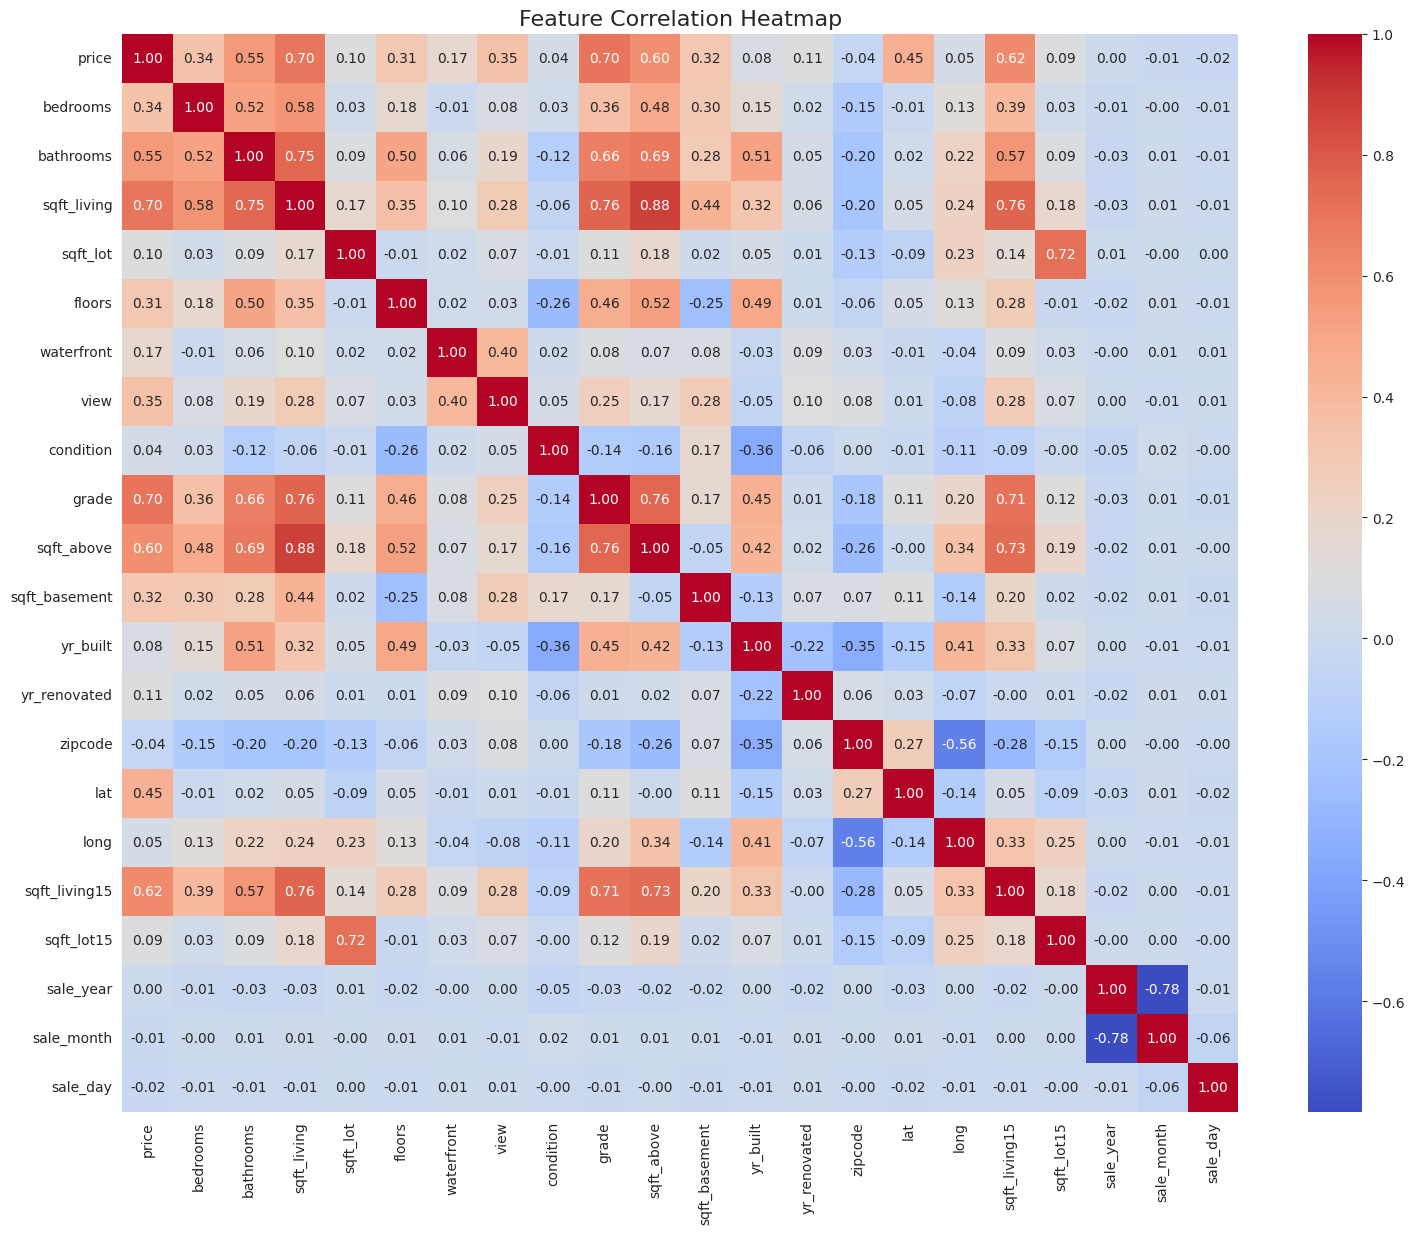


Feature Engineering complete.

Building and training the LightGBM model...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002419 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2323
[LightGBM] [Info] Number of data points in the train set: 17290, number of used features: 21
[LightGBM] [Info] Start training from score 13.045168
Model training complete.

--- Model Performance ---
Root Mean Squared Error (RMSE): 0.1583
R-squared (R²): 0.9121 (The model explains ~91.21% of the variance in price)

Generating feature importance insights...


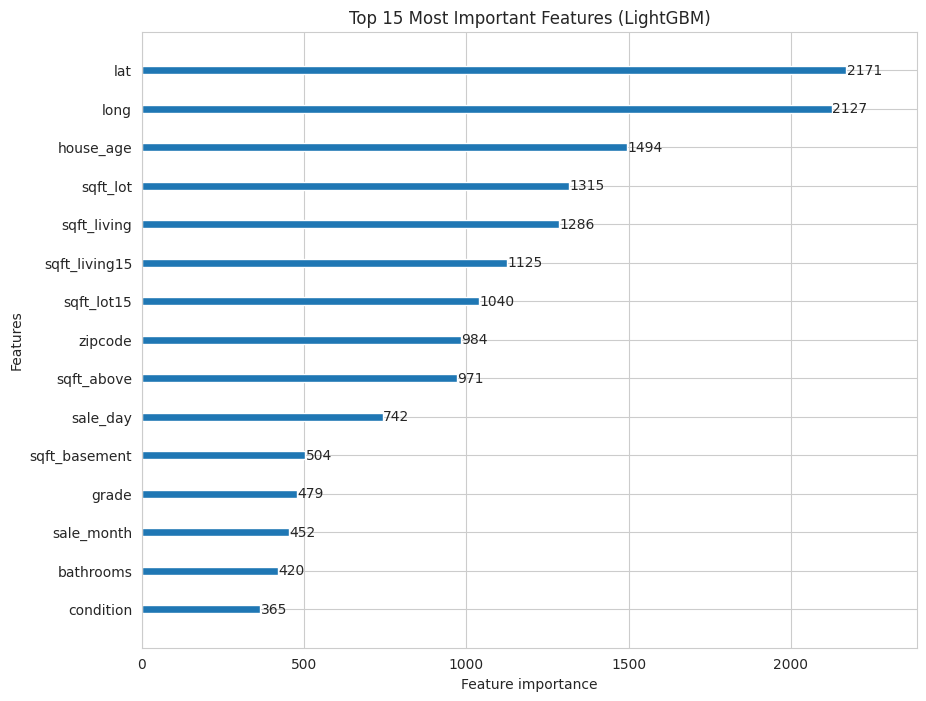


--- Sample of Predictions vs. Actual Prices ---
       Actual Price  Predicted Price  Difference ($)
3268       732000.0        747698.91       -15698.91
10408      185000.0        254378.19       -69378.19
3200       178000.0        279244.10      -101244.10
19266      302000.0        314868.71       -12868.71
21447      425000.0        410878.31        14121.69
10302      464000.0        518813.85       -54813.85
15595      383900.0        390522.39        -6622.39
2559       890000.0        834215.85        55784.15
2141        82500.0        147661.87       -65161.87
10363      375000.0        380407.97        -5407.97

--- Project Finished ---


In [1]:
# =============================================================================
# STEP 1: INSTALL AND IMPORT LIBRARIES
# =============================================================================
# LightGBM is a powerful and fast alternative to XGBoost

!pip install lightgbm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb

# Set a professional plot style
sns.set_style('whitegrid')
print("--- Project: Advanced House Price Prediction ---")
print("Setup complete. Using LightGBM model.")

# =============================================================================
# STEP 2: LOAD AND PREPARE DATA
# =============================================================================
try:
    df = pd.read_csv('/content/drive/MyDrive/kc_house_data.csv')
    print("\nDataset loaded successfully.")
except FileNotFoundError:
    print("\nError: kc_house_data.csv not found. Please upload it to the Colab session.")
    exit()

# Convert 'date' to datetime object
df['date'] = pd.to_datetime(df['date'])
# Engineer new features
df['sale_year'] = df['date'].dt.year
df['sale_month'] = df['date'].dt.month
df['sale_day'] = df['date'].dt.day

# Drop the 'id' and 'date' columns. Date will be replaced by engineered features.
df = df.drop(['id', 'date'], axis=1)

# =============================================================================
# STEP 3: EXPLORATORY DATA ANALYSIS (EDA)
# =============================================================================
print("\nPerforming Exploratory Data Analysis (EDA)...")

# --- 3.1: Analyze the Target Variable (Price) ---
# We visualize the original price distribution and then the log-transformed one.
# Normalizing the price helps the model perform better.
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['price'], kde=True, bins=50)
plt.title('Original Distribution of House Prices')

# Apply log-transformation to normalize the price distribution
df['price'] = np.log1p(df['price'])

plt.subplot(1, 2, 2)
sns.histplot(df['price'], kde=True, bins=50, color='green')
plt.title('Log-Transformed Distribution (Normalized)')
plt.xlabel('Log of Price')
plt.tight_layout()
plt.show()

# --- 3.2: Correlation Heatmap ---
# This helps us see which features are most strongly related to the price.
plt.figure(figsize=(18, 14))
correlation = df.corr(numeric_only=True)
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap', fontsize=16)
plt.show()

# =============================================================================
# STEP 4: FEATURE ENGINEERING
# =============================================================================
# We create new, more informative features from the existing data.
current_year = 2025 # Using a fixed recent year for consistency
df['house_age'] = current_year - df['yr_built']
df['was_renovated'] = df['yr_renovated'].apply(lambda yr: 0 if yr == 0 else 1)

# Drop the original columns that have been replaced by these new features
df_model = df.drop(['yr_built', 'yr_renovated'], axis=1)
print("\nFeature Engineering complete.")

# =============================================================================
# STEP 5: MODEL BUILDING AND TRAINING
# =============================================================================
print("\nBuilding and training the LightGBM model...")

# Define Features (X) and Target (y)
X = df_model.drop('price', axis=1)
y = df_model['price']

# Split Data into Training and Validation Sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the LightGBM Regressor
model = lgb.LGBMRegressor(
    objective='regression',
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42,
    n_jobs=-1
)

# Train the model using early stopping to prevent overfitting
model.fit(X_train, y_train,
          eval_set=[(X_val, y_val)],
          eval_metric='rmse',
          callbacks=[lgb.early_stopping(100, verbose=False)])

print("Model training complete.")

# =============================================================================
# STEP 6: EVALUATION AND RESULTS
# =============================================================================
# Make predictions on the unseen validation data
y_pred = model.predict(X_val)

# --- 6.1: Evaluate Model Performance ---
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print("\n--- Model Performance ---")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f} (The model explains ~{r2:.2%} of the variance in price)")

# --- 6.2: Feature Importance ---
print("\nGenerating feature importance insights...")
lgb.plot_importance(model, max_num_features=15, figsize=(10, 8))
plt.title('Top 15 Most Important Features (LightGBM)')
plt.show()

# =============================================================================
# STEP 7: VIEW PREDICTIONS
# =============================================================================
# Create a DataFrame to compare actual vs. predicted prices for a sample of houses.
# We use np.expm1() to reverse the log transformation and see the actual dollar values.
results_df = pd.DataFrame({
    'Actual Price': np.expm1(y_val),
    'Predicted Price': np.expm1(y_pred)
})
results_df['Difference ($)'] = results_df['Actual Price'] - results_df['Predicted Price']

# Show a random sample of 10 predictions to see how the model performed
print("\n--- Sample of Predictions vs. Actual Prices ---")
print(results_df.sample(10).round(2))

print("\n--- Project Finished ---")